In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB1, EfficientNetV2B2, EfficientNetV2B3, EfficientNetV2S, EfficientNetV2M
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
base = './Datasets'
image_height, image_width = 224, 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(base, validation_split=0.4, seed=128, subset='training', image_size=(image_height, image_width), batch_size=20, shuffle=True)

val_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(base, validation_split=0.4, seed=128, subset='validation', image_size=(image_height, image_width), batch_size=20, shuffle=True)

val_size = int(0.5 * len(val_test_dataset))

test_dataset = val_test_dataset.skip(val_size)
val_dataset = val_test_dataset.take(val_size)

print(f"Train batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Found 19852 files belonging to 10 classes.
Using 11912 files for training.
Found 19852 files belonging to 10 classes.
Using 7940 files for validation.
Train batches: 596
Validation batches: 198
Test batches: 199


In [3]:
print(train_dataset.class_names)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [4]:
'''
augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.3, fill_mode='nearest'),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(factor=0.2),
])
'''

augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest')
])

In [5]:
train_dataset = train_dataset.map(lambda x, y: (augmentation(x), y)).shuffle(1024).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [6]:
for images, labels in train_dataset.take(1):
  print(images.shape)

(20, 224, 224, 3)


In [7]:
base = EfficientNetV2B2(input_shape=(image_height, image_width, 3), include_top=False, weights='imagenet')
base.trainable = False

In [8]:
model = Sequential([
    Input(shape=(image_height, image_width, 3)),
    base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(
), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1408)           │         5,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,442,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,232,168 (39.03 MB)

 Trainable params: 1,457,930 (5.56 MB)

 Non-trainable params: 8,774,238 (33.47 MB)

In [9]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath='Model V2B2.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

'''
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):

        if (logs.get('val_accuracy') > 0.9 and logs.get('val_loss') < 0.5):

            print('Congratulation, your model is good enough!')

            self.model.stop_training = True

        elif (logs.get('accuracy') > logs.get('val_accuracy')):

            print('Training stopped because the model is overfitting!')

            self.model.stop_training = True
'''

"\nearly_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)\n\n\nclass CustomCallback(tf.keras.callbacks.Callback):\n\n    def on_epoch_end(self, epoch, logs=None):\n\n        if (logs.get('val_accuracy') > 0.9 and logs.get('val_loss') < 0.5):\n\n            print('Congratulation, your model is good enough!')\n\n            self.model.stop_training = True\n\n        elif (logs.get('accuracy') > logs.get('val_accuracy')):\n\n            print('Training stopped because the model is overfitting!')\n\n            self.model.stop_training = True\n"

In [10]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[checkpoint, lr_scheduler])

Epoch 1/20
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6687 - loss: 5.6328
Epoch 1: val_loss improved from inf to 2.12088, saving model to Model V2B2.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 339s 428ms/step - accuracy: 0.6688 - loss: 5.6305 - val_accuracy: 0.8828 - val_loss: 2.1209 - learning_rate: 0.0010
Epoch 2/20
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7579 - loss: 2.2784
Epoch 2: val_loss improved from 2.12088 to 1.55956, saving model to Model V2B2.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 252s 423ms/step - accuracy: 0.7579 - loss: 2.2781 - val_accuracy: 0.8879 - val_loss: 1.5596 - learning_rate: 0.0010
Epoch 3/20
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.7571 - loss: 1.9632
Epoch 3: val_loss did not improve from 1.55956
596/596 ━━━━━━━━━━━━━━━━━━━━ 253s 425ms/step - accuracy: 0.7571 - loss: 1.9632 - val_accuracy: 0.8861 - val_loss: 1.5789 - learning_rate: 0.0010
Epoch 4/20
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.7655 - loss: 1.9521


In [11]:
def plotGraph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

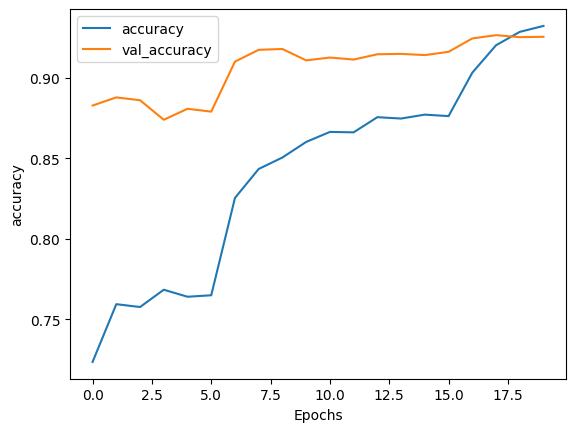

In [12]:
plotGraph(history, 'accuracy')

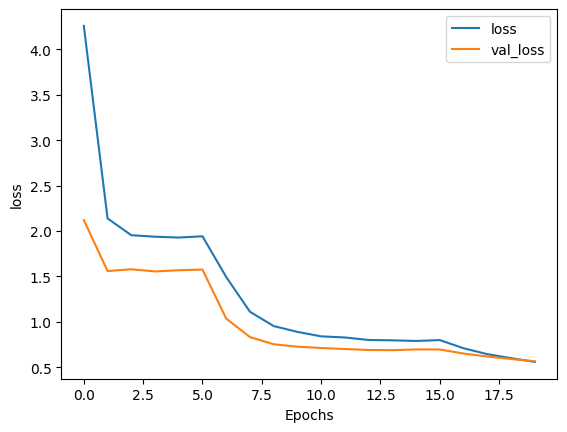

In [13]:
plotGraph(history, 'loss')

In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss : {test_loss:.2f}')
print(f'Test Accuracy : {test_accuracy:.2f}')

199/199 ━━━━━━━━━━━━━━━━━━━━ 80s 395ms/step - accuracy: 0.9247 - loss: 0.5841
Test Loss : 0.57
Test Accuracy : 0.93


In [15]:
model.save('Model V2B2.h5')

In [16]:
'''
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
'''

"\nmodel = Sequential([\n    Input(shape=(224, 224, 3)),\n    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),\n    BatchNormalization(),\n    MaxPooling2D((2, 2)),\n    Dropout(0.4),\n\n    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),\n    BatchNormalization(),\n    MaxPooling2D((2, 2)),\n    Dropout(0.4),\n\n    GlobalAveragePooling2D(),\n    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),\n    BatchNormalization(),\n    Dropout(0.5),\n    Dense(7, activation='softmax')\n])\n\nmodel.summary()\nmodel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])\n"

In [17]:
'''
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[lr_scheduler])
'''

'\nhistory = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[lr_scheduler])\n'

In [18]:
'''
Best model architecture so far :
augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest')
])

base = EfficientNetV2B2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base.trainable = False

model = Sequential([
    Input(shape=(224, 224, 3)),
    base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(7, activation='softmax')
])
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2.0000e-04), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
'''

"\nBest model architecture so far :\naugmentation = Sequential([\n    tf.keras.layers.RandomFlip('horizontal_and_vertical'),\n    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),\n    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),\n    tf.keras.layers.RandomBrightness(factor=0.2),\n    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest')\n])\n\nbase = EfficientNetV2B2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')\nbase.trainable = False\n\nmodel = Sequential([\n    Input(shape=(224, 224, 3)),\n    base,\n    GlobalAveragePooling2D(),\n    BatchNormalization(),\n    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),\n    Dropout(0.4),\n    BatchNormalization(),\n    Dense(7, activation='softmax')\n])\nmodel.summary()\nmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2.0000e-04), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])\n"